In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
sys.path.insert(0, "../src")
import sys 
from skimage import data, io, filters
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# from utils.dice_score import multiclass_dice_coeff, dice_coeff
from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler


from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import my_data
# from utils.dice_score import dice_loss
from evaluate import evaluate
from unet import UNet
from predict import predict_img
import seaborn as sns
import pickle as pkl

pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = False # torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 


In [51]:
results = pd.concat(results_list, axis=1).T.infer_objects()

results.experiment_name.unique()
results['best_val_score'] = [max(x) for x in results.val_scores]

In [52]:
results.experiment_name.unique()

array(['BaselineFullDataset', 'BaselineNoAquisition'], dtype=object)

In [53]:
results = results[results.experiment_name == "BaselineFullDataset"]
# results = results[results.dataset == "lno"]

In [54]:
results[['experiment_name','best_val_score', 'cost_function']].groupby('cost_function').mean()

,best_val_score
cost_function,
uncertainty_cost,0.96


In [55]:
results[['experiment_name','best_val_score', 'cost_function']]

,experiment_name,best_val_score,cost_function
0,BaselineFullDataset,0.96,uncertainty_cost
5,BaselineFullDataset,0.96,uncertainty_cost
8,BaselineFullDataset,0.96,uncertainty_cost


In [56]:
results = results.reset_index()

In [57]:
x,y, _, _ = my_data.load_layer_data(oj(data_path, 'lno'))
data_mean = x[:-4].mean()
data_std = x[:-4].std()
y_second= my_data.load_single_file(oj(data_path, 'lno_second_annotation'))

ImageJ series: invalid metadata or corrupted file ()


TrainSet_v2_secondAnnotation.tif
(2048, 2048)


In [63]:
net = UNet(1, 3, bilinear = results.bilinear[0]).to(device)
# load state dict
net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] ,results.file_name[0]+".pt")))
net.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

# Human comparison

In [58]:
output_list = []
output_list.append(y[-1])
output_list.append(y_second[3])
real_val_list = []

In [59]:
test_img_np  = ((x[-1][None, ].astype(np.float32) -data_mean)/data_std)

In [64]:
test_img_np  = ((x[-1][None, ].astype(np.float32) -data_mean)/data_std)
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]

    print((y[img_idx] ==np.argmax(output, axis=0)).mean())

In [43]:
for i in range(5):
    my_models = [UNet(1, 3, bilinear = results.bilinear[0]).to(device) for i, _ in enumerate(results.file_name)] 
    print(i)

    net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] ,results.file_name[i]+".pt")))
    net= net.to(device).eval()
    with torch.no_grad():
        img_t = torch.Tensor(test_img_np).to(device)
        output = net.forward(img_t).cpu().detach().numpy()[0]
        nn_y = np.argmax(output, axis=0) 
        real_val_list.append(output == output.max(axis=0))
        output_list.append(np.copy(nn_y))



0


NameError: name 'net' is not defined

In [52]:
(np.argmax(np.asarray(real_val_list).mean(axis=0), axis=0) ==output_list[1]).mean()

0.9685964584350586

In [44]:
agreement_matrix = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        agreement_matrix[i,j] = (output_list[i] == output_list[j]).mean()

IndexError: list index out of range

In [45]:
agreement_matrix[0,1]

0.014384269714355469

In [55]:
bah_list = []
for i in range(2,7):

    bah_list.append(1-  ((output_list[1] != output_list[i]) * (output_list[0] != output_list[i])).mean())
np.asarray(bah_list).mean()

0.9801799774169921

In [56]:
bah_list

[0.977696418762207,
 0.9814834594726562,
 0.9801397323608398,
 0.9818077087402344,
 0.9797725677490234]

In [57]:
1-  ((output_list[1] != output_list[i]) * (output_list[0] != output_list[i])).mean()

0.9797725677490234

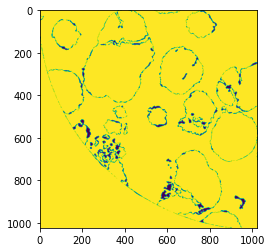

In [58]:
plt.imshow(output_list[0] == output_list[1])

In [59]:
agreement_matrix[1,2:].std()

0.0014117609118588315

In [60]:
agreement_matrix[2,3:].mean()

0.9902455806732178

In [155]:
torch.nn.functional.one_hot(torch.Tensor(output_list[3]))

RuntimeError: one_hot is only applicable to index tensor.

In [ ]:
plt.imshow

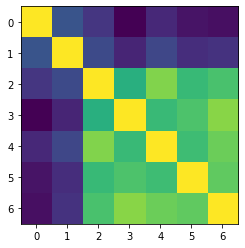

In [121]:
plt.imshow(agreement_matrix[-1])

In [90]:
print("NN agreement: ", (nn_y == y[img_idx]).mean())

NN agreement:  0.9667758941650391


In [91]:
print("NN agreement: ", (nn_y == y_second[3]).mean())

NN agreement:  0.9705038070678711


In [146]:
torch.Tensor(output_list[0]).size()

torch.Size([1024, 1024])

In [ ]:
    test_img_np  = ((x[-1][None, ].astype(np.float32) -data_mean)/data_std)
    with torch.no_grad():
        img_t = torch.Tensor(test_img_np).to(device)
        output = net.forward(img_t).cpu().detach().numpy()[0]

        print((y[img_idx] ==np.argmax(output, axis=0)).mean())

In [ ]:
output.shape

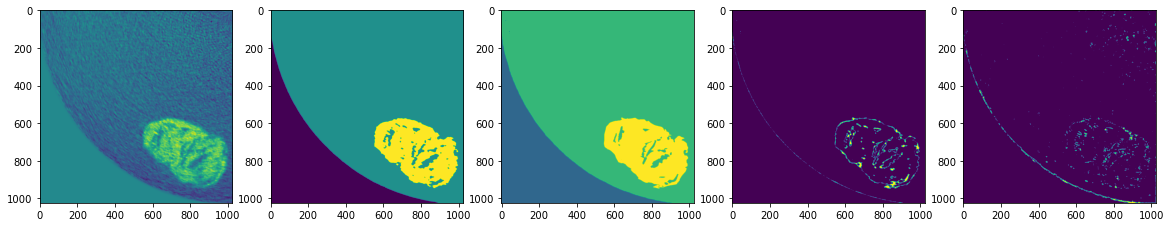

In [196]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .01)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,0])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(y[img_idx])
axes[3].imshow(y[img_idx] !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

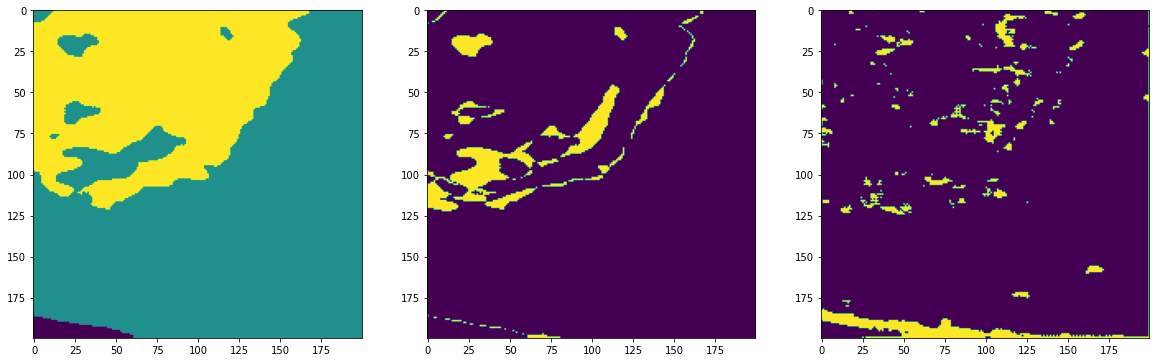

In [198]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .02)

fig, axes = plt.subplots(ncols = 3, figsize = (20,8))
# axes[0].imshow(x[img_idx,2])
axes[0].imshow(np.argmax(output, axis=0)[-200:,-200:])
# axes[2].imshow(show_img)
axes[1].imshow((y[img_idx] !=np.argmax(output, axis=0) )[-200:,-200:])

axes[2].imshow(std_large[-200:,-200:])

In [189]:
(y[img_idx] !=np.argmax(output, axis=0))[np.where(std_large)].mean()

0.08686198214694438

In [190]:
(y[img_idx] !=np.argmax(output, axis=0))[np.where(1-std_large)].mean() 

0.03779759634110594

In [165]:
.99*.02

0.0198

In [166]:
.01*.23

0.0023

In [178]:
(y[img_idx] ==np.argmax(output, axis=0)).mean()

0.9597492218017578

In [ ]:
.

In [54]:
correct = np.reshape(show_img !=np.argmax(output, axis=0),-1)
std = np.reshape(output.std(axis=0), -1)

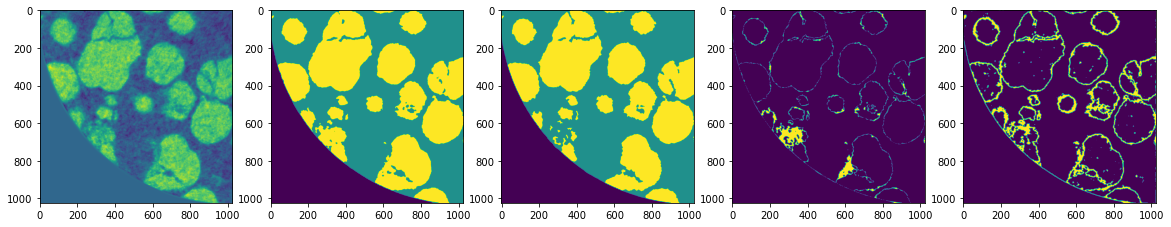

In [55]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,2])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

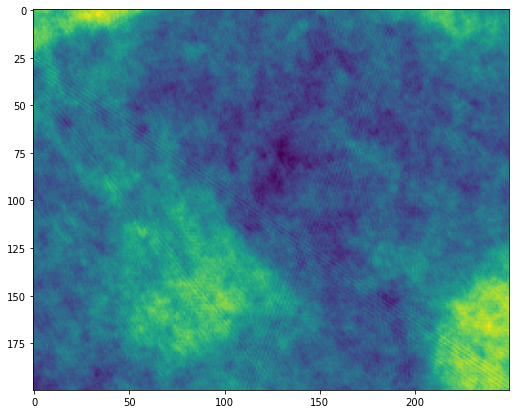

In [104]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 1, figsize = (20,7))
axes.imshow(x[img_idx,2][200:400,350:600])

# axes[4].imshow(std_large)

In [14]:
x.shape

(24, 5, 1024, 1024)

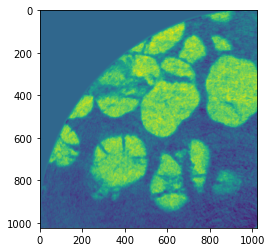

In [15]:
plt.imshow(x[0,2])

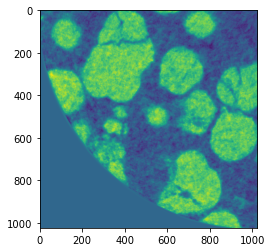

In [20]:
plt.imshow(x[-1,2])

In [ ]:
x[img_idx,2][200:400,350:600]